Training the model that takes the complete sequence and the evaluation calculates AUCs on separate task IDs. <br>
Evaluation method stays the same as separate_models.ipynb

In [1]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

This code can work with tf.VERSION = '1.4.1' (for MacOS High Sierra); functions may change for other versions.

Model Parameters:

In [2]:
training_set_split = 0.8
validation_set_split = 0.1
#learning_rate = np.logspace(-5,0,5)
learning_rate = [0.01]
num_units = 50 #number of units in RNN cell
training_steps = 1000 #number of epochs (when convergence stopping not active)
display_step = 20 #number of epochs after which to display progress
optimize_using = "adam" #other option: "momentum", "adagrad", "adam"

In [3]:
print("Tensorflow version: " + str(tf.VERSION))

Tensorflow version: 1.4.1


Loading JSON file into dictionary called 'student_vectors'

In [4]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
filepath2 = "../../../student_vectors_n_task_10_n_limit_100000.json"
student_vectors2 = json.load(open(filepath))
student_vectors = json.load(open(filepath2))

Collecting unique CCSSM labels and Task IDs

In [5]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique task IDs: 10
Number of students: 11659


Creating 1-hot encoding for Task IDs and CCSSM Labels

In [6]:
#pre-processing for using MultiLabelBinarizer
temp_ids = []
for i in task_ids:
    temp_ids.append([i])

#generating encodings
enc = MultiLabelBinarizer()
task_ids_1hot = (enc.fit_transform(temp_ids)).astype(float)
task_ids_classes = enc.classes_
task_ids_dict = dict(zip(task_ids, task_ids_1hot))
# print("\n1-hot encoding for task IDs:")
# pp.pprint(task_ids_dict)

Generating input sequences of interactions to feed the network. Say we have 3 task IDs; here is an example of interaction vectors generated:
1. User correctly solves task 2 of label 3: [010   000]
2. User incorrectly solves task 1 of label 2: [000   100]

1-hot representation of task IDs: 
task ID 1: 1,0,0
task ID 2: 0,1,0
task ID 3: 0,0,1

In [7]:
sequences = []
output_y = []
seqlen = []
sequences_lengths1 = [] #for passing to mask
incorrect_tid_vec = np.zeros((len(task_ids)), dtype=np.float)
for i in student_vectors:
    temp_seq = []
    temp_seq.append(np.concatenate([incorrect_tid_vec,incorrect_tid_vec])) #for taking first prediction into account
    for j in student_vectors[i]:
        if(j['second_try'] == False): #ignoring second_try
            if(j['correct'] == True):
                vec = np.concatenate([task_ids_dict[j['task_id']],incorrect_tid_vec])
                temp_seq.append(vec)
            else:
                vec = np.concatenate([incorrect_tid_vec,task_ids_dict[j['task_id']]])
                temp_seq.append(vec)
    if(len(temp_seq)>1):
        seqlen.append(len(temp_seq)-1)
        sequences_lengths1.append([len(temp_seq)-1]) 
        last_one = temp_seq.pop() #remove last interaction vector
        sequences.append(temp_seq) #add it to x
        first_one = temp_seq.pop(0) #remove first interaction vector
        temp_seq.append(last_one)
        output_y.append(temp_seq) #concatenate with last vector, and append to output! 
    
# print("Sample interaction vector: ")
# pp.pprint(sequences[0][0])
length_interaction_vector = 2*(len(task_ids)) #length of interaction vector

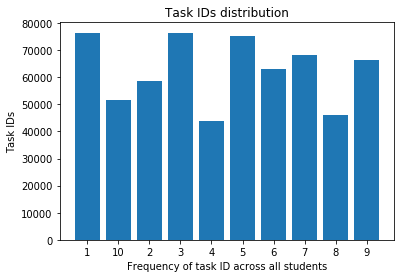

Task IDs mapping: 
Task ID -> 1zsCldT4p8.set1(1) is attempted 76458 times. Max seq len: 240
Task ID -> kvig7fcCVc.partb(2) is attempted 58768 times. Max seq len: 61
Task ID -> p7cfRPp-kQ.partb(3) is attempted 76279 times. Max seq len: 147
Task ID -> dTZlXODVzW.partb(4) is attempted 43769 times. Max seq len: 137
Task ID -> 1zsCldT4p8.set2(5) is attempted 75166 times. Max seq len: 210
Task ID -> UlJYoQjOUR.partb(6) is attempted 63034 times. Max seq len: 193
Task ID -> 9wRCzK1G7F.partb(7) is attempted 68238 times. Max seq len: 180
Task ID -> 2yCqg9SbT0.set1(8) is attempted 46153 times. Max seq len: 119
Task ID -> DebcfZEEmI.proper_fractions(9) is attempted 66271 times. Max seq len: 132
Task ID -> nl-M69Ez9k.parta(10) is attempted 51483 times. Max seq len: 145


In [8]:
#frequency distribution of taskids
cnt2 = Counter()
another_2 = {}
seqlen_tasks = {}
temp_seqlen = {}
position_2 = 1
for i in student_vectors:
    for k in temp_seqlen:
        temp_seqlen[k] = 0
    for j in student_vectors[i]:
        if(j['second_try'] == False):
            if j['task_id'] not in another_2:
                another_2[j['task_id']] = str(position_2)
                position_2 = position_2 + 1
            if j['task_id'] not in seqlen_tasks:
                seqlen_tasks[j['task_id']] = []

            if j['task_id'] not in temp_seqlen:
                temp_seqlen[j['task_id']] = 1
            else:
                temp_seqlen[j['task_id']] += 1
            cnt2[another_2[j['task_id']]] += 1
    for k in seqlen_tasks:
        seqlen_tasks[k].append(temp_seqlen[k])
plt.bar(cnt2.keys(), cnt2.values())
plt.title("Task IDs distribution")
plt.xlabel("Frequency of task ID across all students")
plt.ylabel("Task IDs")
plt.show()
print("Task IDs mapping: ")
for i in another_2:
    print("Task ID -> "+str(i)+"("+str(another_2[i])+") is attempted " + str(cnt2[another_2[i]]) + " times." + " Max seq len: "+str(max(seqlen_tasks[i])))

Finding maximum sequence length.

In [9]:
max_seqlen = max(seqlen)
print("Maximum sequence length: "+str(max_seqlen))

Maximum sequence length: 1326


Padding the sequences according to maximum sequence length. Making padded sequences of shape: number of students, maximum sequence length, length of interaction vector.

In [10]:
padded_sequences = np.zeros(shape=(len(student_vectors),max_seqlen,length_interaction_vector),dtype=float)
for i in range(len(sequences)):
    for j in range(len(sequences[i])):
        padded_sequences[i][j] = sequences[i][j]
print("Sequences have been padded according to the maximum sequence length. Final shape: " + str(padded_sequences.shape))

padded_output = np.zeros(shape=(len(student_vectors),max_seqlen,length_interaction_vector),dtype=float)
for i in range(len(output_y)):
    for j in range(len(output_y[i])):
        padded_output[i][j] = output_y[i][j]

Sequences have been padded according to the maximum sequence length. Final shape: (11659, 1326, 20)


Split the data into training and testing sets. The code for random split is ready.<br>
Review: **Try using sklearn**

In [11]:
#split = round((training_set_split+validation_set_split)*len(student_vectors))
split = int((training_set_split)*len(student_vectors))

tmp_rnd = 0
training_x = np.zeros_like(padded_sequences[:split])
training_y = np.zeros_like(np.asarray(padded_output)[:split])
training_seqlen = np.zeros_like(seqlen[:split])

test_x = np.zeros_like(padded_sequences[split:])
test_y = np.zeros_like(np.asarray(padded_output)[split:])
test_seqlen = np.zeros_like(seqlen[split:])

itr = 0
itr_tr = 0
itr_te = 0
# import random
# #separating training and testing sets randomly
# for i in range(len(padded_sequences)):
#     if(random.uniform(0, 1) <= (training_set_split+validation_set_split) and itr_tr < split):
#         #add to training
#         training_x[itr_tr] = padded_sequences[itr]
#         training_y[itr_tr] = np.asarray(padded_output)[itr]
#         training_y_taskid[itr_tr] = np.asarray(padded_output_taskid)[itr]
#         training_seqlen[itr_tr] = seqlen[itr]
#         itr_tr = itr_tr + 1
#     elif(itr_te < (len(student_vectors) - split)):
#         #add to testing
#         test_x[itr_te] = padded_sequences[itr]
#         test_y[itr_te] = np.asarray(padded_output)[itr]
#         test_y_taskid[itr_te] = np.asarray(padded_output_taskid)[itr]
#         test_seqlen[itr_te] = seqlen[itr]
#         itr_te = itr_te + 1
#     else:
#         #add to training
#         training_x[itr_tr] = padded_sequences[itr]
#         training_y[itr_tr] = np.asarray(padded_output)[itr]
#         training_y_taskid[itr_tr] = np.asarray(padded_output_taskid)[itr]
#         training_seqlen[itr_tr] = seqlen[itr]
#         itr_tr = itr_tr + 1
#     itr = itr + 1

#separating training & validation set
training_x = padded_sequences[:split]
training_y = np.asarray(padded_output)[:split]
training_seqlen = seqlen[:split]

#separating test set
test_x = padded_sequences[split:]
test_y = np.asarray(padded_output)[split:]
test_seqlen = seqlen[split:]

# #generating validation and training sets by implementing k-fold cross validation (k = maximum_position)
# validation_set_size = math.floor(validation_set_split * len(student_vectors))
# training_set_size = len(training_x) - validation_set_size
# maximum_position = math.floor(len(training_x) / validation_set_size)

# def get_next_train_valid_set(position):
#     if(position>=maximum_position):
#         position = position % maximum_position
#     print("Picking validation set from position: "+str(position))
#     valid_start = position*validation_set_size
#     valid_end = valid_start + validation_set_size
    
#     valid_set_x = training_x[valid_start : valid_end]
#     valid_set_y = training_y[valid_start : valid_end]
#     valid_set_y_taskid = np.asarray(training_y_taskid)[valid_start : valid_end]
#     valid_set_seqlen = np.asarray(training_seqlen[valid_start:valid_end])
    
#     train_set_x = np.concatenate((training_x[:valid_start], training_x[valid_end:]))
#     train_set_y = np.concatenate((training_y[:valid_start], training_y[valid_end:]))
#     train_set_y_taskid = np.concatenate((np.asarray(training_y_taskid)[:valid_start], np.asarray(training_y_taskid)[valid_end:]))
#     train_set_seqlen = np.concatenate((np.asarray(training_seqlen)[:valid_start],np.asarray(training_seqlen)[valid_end:]))
    
#     if(len(train_set_x) != training_set_size): #test
#         print("that's not good it is:")
#         print(train_set_x.shape)
    
#     return (train_set_seqlen,valid_set_seqlen,valid_set_x,valid_set_y,valid_set_y_taskid,train_set_x,train_set_y,train_set_y_taskid)

# print("Splitting "+str(len(student_vectors))+" rows randomly into "+str(training_set_size)+ " for training, "+str(validation_set_size)+" for validation and "+str(len(test_x)) + " for testing.")
# print("Implemented "+str(maximum_position)+"-fold cross validation.")
print("Splitting "+str(len(student_vectors))+" rows (or students) into "+str(len(training_x))+ " for training and "+str(len(test_x)) + " for testing.")

Splitting 11659 rows (or students) into 9327 for training and 2332 for testing.


Building the model

In [12]:
tf.reset_default_graph()
tf.set_random_seed(1234)
#defining placeholders
x = tf.placeholder(tf.float32, [None, max_seqlen, length_interaction_vector])
y = tf.placeholder(tf.float32, [None, max_seqlen, length_interaction_vector])
seqlen_tf = tf.placeholder(tf.float32,[None])
condition = tf.placeholder(tf.int32, shape=[], name="condition")

#defining tensorflow variables
learning_tf_rate = tf.Variable(0.0, name="learning_tf_rate",dtype=tf.float32,trainable=False)

#dynamic RNN definition
def dynamicRNN(x):
    rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
    outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
    out_size = int(length_interaction_vector / 2)
    outputs = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn = tf.nn.sigmoid, weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
    opposites = tf.subtract(tf.ones(tf.shape(outputs)),outputs)
    outputs1 = tf.concat([outputs,opposites],2)
    return outputs1

#making predictions
pred = dynamicRNN(x)
pred = pred*y
# Define loss and optimizer
cost1 = tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y)
mask = tf.cond(condition < 1, lambda: tf.cast(tf.sequence_mask(lengths=sequences_lengths1[:split], maxlen = max_seqlen), tf.float32), lambda: tf.cast(tf.sequence_mask(lengths=sequences_lengths1[split:], maxlen = max_seqlen), tf.float32))
cost1 = tf.multiply(cost1,tf.transpose(mask, perm=[0, 2, 1]))
cost1 = tf.reduce_sum(cost1, 1)
cost1 /= tf.cond(condition < 1, lambda: tf.cast(sequences_lengths1[:split],tf.float32), lambda: tf.cast(sequences_lengths1[split:],tf.float32) )
cost = tf.reduce_mean(cost1)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_tf_rate).minimize(cost)

saver = tf.train.Saver(max_to_keep=5)

Partitioning test set into separate task IDs

In [13]:
test_x_list_dict = {}
test_y_list_dict = {}
test_seqlen_list_dict = {}
train_x_list_dict = {}
train_y_list_dict = {}
train_seqlen_list_dict = {}
split_dict = {}
for i in another_2: 
    #generate encoding here! 
    sequences = []
    sequences_lengths = []
    for p in student_vectors:
        interactions = []
        interactions.append(np.concatenate([incorrect_tid_vec,incorrect_tid_vec])) #for getting the first prediction!
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    vec = np.concatenate([task_ids_dict[j['task_id']],incorrect_tid_vec])
                    interactions.append(vec)
                else:
                    interactions.append(np.concatenate([incorrect_tid_vec,task_ids_dict[j['task_id']]]))
        if(len(interactions) > 1):
            sequences_lengths.append(len(interactions)-1)
            sequences.append(interactions)
    split = int(0.8*len(sequences))
    #add padding
    padded_sequences = np.zeros([len(sequences),max_seqlen+1,length_interaction_vector])
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]
    test_x_list_dict[i] = padded_sequences[split:,:-1]
    test_y_list_dict[i] = padded_sequences[split:,1:]
    test_seqlen_list_dict[i] = sequences_lengths[split:]
    train_x_list_dict[i] = padded_sequences[:split,:-1]
    train_y_list_dict[i] = padded_sequences[:split,1:]
    train_seqlen_list_dict[i] = sequences_lengths[:split]

In [14]:
np.set_printoptions(threshold=np.nan)

import math
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def calculate_auc (y_true,y_pred,sequence_lengths=[],plot=False,debug=False):
    if sequence_lengths == []:
        return roc_auc_score(y_true, y_pred)
    else:
        con_y_true = np.zeros([sum(sequence_lengths),length_interaction_vector])
        con_y_pred = np.zeros([sum(sequence_lengths),length_interaction_vector])
        index = 0
        for i in range(len(y_true)): #per student
            for j in range(sequence_lengths[i]): #up to the sequence length
                con_y_true[index] = y_true[i][j]
                con_y_pred[index] = y_pred[i][j]
                index += 1
        con1_y_true = np.zeros([sum(sequence_lengths)])
        con1_y_pred = np.zeros([sum(sequence_lengths)])
        
        for l in range(sum(sequence_lengths)):
            index_one = np.argmax(con_y_true[l])
            if(index_one >= int(length_interaction_vector/2)):
                index_two = index_one - int(length_interaction_vector/2)
            else:
                index_two = index_one
                index_one = index_one + int(length_interaction_vector/2)
            if(np.argmax(con_y_true[l]) == index_one): #true is incorrect
                con1_y_true[l] = 0.
                con1_y_pred[l] = 1.0 - con_y_pred[l][index_one]
            elif(np.argmax(con_y_true[l]) == index_two):
                con1_y_true[l] = 1.
                con1_y_pred[l] = con_y_pred[l][index_two]
        debug=False
        if(debug):
            print(np.c_[con1_y_true,con1_y_pred])
        fpr, tpr, thresholds = roc_curve(con1_y_true, con1_y_pred)
        #print("tpr: "+str(tpr) + ", fpr: "+str(fpr) + ", thresholds: "+str(thresholds))
        if(plot):
            return [roc_auc_score(con1_y_true, con1_y_pred),fpr,tpr]
        else:
            return roc_auc_score(con1_y_true, con1_y_pred)

Training the Model

In [ ]:
true_all_tasks = {}
true_all_tasks['train'] = {}
true_all_tasks['test'] = {}
predictions_all_tasks = {}
predictions_all_tasks['train'] = {}
predictions_all_tasks['test'] = {}
seqlen_all_tasks = {}
seqlen_all_tasks['train'] = {}
seqlen_all_tasks['test'] = {}
c_seqlen = {}
c_seqlen['train'] = {}
c_seqlen['test'] = {}
for i in another_2:
    seqlen_all_tasks['train'][i] = []
    seqlen_all_tasks['test'][i] = []
    predictions_all_tasks['train'][i] = []
    predictions_all_tasks['test'][i] = []
    true_all_tasks['train'][i] = []
    true_all_tasks['test'][i] = []
    c_seqlen['train'][i] = []
    c_seqlen['test'][i] = []
seqlen_all_tasks['train']['overall'] = []
seqlen_all_tasks['test']['overall'] = []
predictions_all_tasks['train']['overall'] = []
predictions_all_tasks['test']['overall'] = []
true_all_tasks['train']['overall'] = []
true_all_tasks['test']['overall'] = []
c_seqlen['train']['overall'] = []
c_seqlen['test']['overall'] = []

with tf.Session() as sess:
    for l_r in learning_rate:
        # Initialize the variables (i.e. assign their default value)
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        #saver.restore(sess, 'combined_model/')
        assign_op = learning_tf_rate.assign(l_r)
        sess.run(assign_op)
        cost_prev = 1.0
        stop = False
        #print("Final Learning Rate: "+str(learning_tf_rate.eval()))
        step = 0
        while(step<=101):
        #for step in range(1, training_steps):
            sess.run(optimizer, feed_dict={x: training_x, y: training_y, seqlen_tf: training_seqlen,condition:0})
            step += 1
            if step % display_step == 0 or step == 1:
                #take backups first
                saver.save(sess, 'combined_model/model.ckpt',global_step=display_step)
#                 save_obj(true_all_tasks,'true_all_tasks')
#                 save_obj(seqlen_all_tasks,'seqlen_all_tasks')
#                 save_obj(predictions_all_tasks,'predictions_all_tasks')
#                 save_obj(c_seqlen,'c_seqlen')
                
                loss = sess.run(cost, feed_dict={x: training_x, y: training_y, seqlen_tf: training_seqlen,condition:0})
                cost_current = loss
                if cost_prev - cost_current <= 0.00005:
                    stop = True
                else:
                    cost_prev = cost_current
    
                #calculate overall training AUC
                pred_train,train_cost = sess.run([pred,cost], feed_dict={x: training_x, y: training_y, seqlen_tf: training_seqlen,condition:0})
                o_train_opts_taskid = calculate_auc(training_y,pred_train,training_seqlen)
                true_all_tasks['train']['overall'].append(training_y)
                predictions_all_tasks['train']['overall'].append(pred_train)
                seqlen_all_tasks['train']['overall'].append(o_train_opts_taskid)
                c_seqlen['train']['overall'].append(training_seqlen)
                # Calculate overall test auc
                pred_test,test_cost = sess.run([pred,cost],feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen,condition:1})
                o_temp_opts_taskid = calculate_auc(test_y,pred_test,test_seqlen)
                true_all_tasks['test']['overall'].append(test_y)
                predictions_all_tasks['test']['overall'].append(pred_test)
                seqlen_all_tasks['test']['overall'].append(o_temp_opts_taskid)
                c_seqlen['test']['overall'].append(test_seqlen)
                #print status
                print("Epoch " + str(step) + ", Train loss = " + str(train_cost) + ", Train AUC = "+str(o_train_opts_taskid) +", Test Loss: "+str(test_cost)+ ", Test AUC: "+str(o_temp_opts_taskid))
                
                #calculate train and test AUCs on task IDs separately!
                for idx,i in enumerate(another_2):
                    pred_train = sess.run(pred, feed_dict={x: train_x_list_dict[i], y: train_y_list_dict[i], seqlen_tf: train_seqlen_list_dict[i] ,condition:0})
                    train_opts_taskid = calculate_auc(train_y_list_dict[i],pred_train,train_seqlen_list_dict[i])
                    true_all_tasks['train'][i].append(train_y_list_dict[i])
                    predictions_all_tasks['train'][i].append(pred_train)
                    seqlen_all_tasks['train'][i].append(train_opts_taskid)
                    c_seqlen['train'][i].append(train_seqlen_list_dict[i])
                    pred_test = sess.run(pred,feed_dict={x: test_x_list_dict[i], y: test_y_list_dict[i], seqlen_tf: test_seqlen_list_dict[i] ,condition:1})
                    temp_opts_taskid = calculate_auc(test_y_list_dict[i],pred_test,test_seqlen_list_dict[i])
                    true_all_tasks['test'][i].append(test_y_list_dict[i])
                    predictions_all_tasks['test'][i].append(pred_test)
                    seqlen_all_tasks['test'][i].append(temp_opts_taskid)
                    c_seqlen['test'][i].append(test_seqlen_list_dict[i])
                    print(str(i) + " -> Train AUC = "+str(train_opts_taskid) + ", Test AUC: "+str(temp_opts_taskid))
                
                #print("Concatenated AUC: Train = "+str(c_train_opts_taskid) + ", Test = "+str(c_temp_opts_taskid))
#                 view_point = np.argsort(test_seqlen)[1]
#                 prediction = sess.run(pred, feed_dict={x: [test_x[view_point]], y: [test_y[view_point]], seqlen_tf: [test_seqlen[view_point]],condition:1})
#                 print("\n\ntrue:prediction\n")
#                 print(np.c_[test_x[view_point][:test_seqlen[view_point]],prediction[0][:test_seqlen[view_point]]])
                print("\n\n")
            
        print("Optimization Finished!")
        for idx,i in enumerate(another_2):
            pred_test = sess.run(pred,feed_dict={x: test_x_list_dict[i], y: test_y_list_dict[i], seqlen_tf: test_seqlen_list_dict[i] ,condition:1})
            true_all_tasks['test'][i].append(test_y_list_dict[i])
            predictions_all_tasks['test'][i].append(pred_test)
            seqlen_all_tasks['test'][i].append(test_seqlen_list_dict[i])
            pred_train = sess.run(pred, feed_dict={x: train_x_list_dict[i], y: train_y_list_dict[i], seqlen_tf: train_seqlen_list_dict[i] ,condition:0})
            true_all_tasks['train'][i].append(train_y_list_dict[i])
            predictions_all_tasks['train'][i].append(pred_train)
            seqlen_all_tasks['train'][i].append(train_seqlen_list_dict[i])
        
        pred_test,test_cost = sess.run([pred,cost],feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen,condition:1})
        true_all_tasks['test']['overall'].append(test_y)
        predictions_all_tasks['test']['overall'].append(pred_test)
        seqlen_all_tasks['test']['overall'].append(test_seqlen)
        c_seqlen['test']['overall'].append(test_seqlen)
        pred_train,train_cost = sess.run([pred,cost], feed_dict={x: training_x, y: training_y, seqlen_tf: training_seqlen,condition:0})
        true_all_tasks['train']['overall'].append(training_y)
        predictions_all_tasks['train']['overall'].append(pred_train)
        seqlen_all_tasks['train']['overall'].append(training_seqlen)
        c_seqlen['train']['overall'].append(training_seqlen)

Epoch 1, Train loss = 0.68168664, Train AUC = 0.6533182445867376, Test Loss: 0.68163747, Test AUC: 0.6542869037569267
1zsCldT4p8.set1 -> Train AUC = 0.600374110821459, Test AUC: 0.5971027248989621
kvig7fcCVc.partb -> Train AUC = 0.7032447640867853, Test AUC: 0.7106950992162261
p7cfRPp-kQ.partb -> Train AUC = 0.693316707049741, Test AUC: 0.7342622757939652
dTZlXODVzW.partb -> Train AUC = 0.6296216586198917, Test AUC: 0.6089523856715873
1zsCldT4p8.set2 -> Train AUC = 0.548633310137118, Test AUC: 0.5379141004153085
UlJYoQjOUR.partb -> Train AUC = 0.5042757831493871, Test AUC: 0.4469207230730544
9wRCzK1G7F.partb -> Train AUC = 0.5302084969020459, Test AUC: 0.5179692009717649
2yCqg9SbT0.set1 -> Train AUC = 0.5754864938768369, Test AUC: 0.5561960528981489
DebcfZEEmI.proper_fractions -> Train AUC = 0.7387827767898163, Test AUC: 0.7232035475303122
nl-M69Ez9k.parta -> Train AUC = 0.4926417800054649, Test AUC: 0.4957860813705136



Epoch 20, Train loss = 0.67711, Train AUC = 0.6781088325589765, 

In [16]:
true_all_tasks = {}
true_all_tasks['train'] = {}
true_all_tasks['test'] = {}
predictions_all_tasks = {}
predictions_all_tasks['train'] = {}
predictions_all_tasks['test'] = {}
seqlen_all_tasks = {}
seqlen_all_tasks['train'] = {}
seqlen_all_tasks['test'] = {}
c_seqlen = {}
c_seqlen['train'] = {}
c_seqlen['test'] = {}
for i in another_2:
    seqlen_all_tasks['train'][i] = []
    seqlen_all_tasks['test'][i] = []
    predictions_all_tasks['train'][i] = []
    predictions_all_tasks['test'][i] = []
    true_all_tasks['train'][i] = []
    true_all_tasks['test'][i] = []
    c_seqlen['train'][i] = []
    c_seqlen['test'][i] = []
seqlen_all_tasks['train']['overall'] = []
seqlen_all_tasks['test']['overall'] = []
predictions_all_tasks['train']['overall'] = []
predictions_all_tasks['test']['overall'] = []
true_all_tasks['train']['overall'] = []
true_all_tasks['test']['overall'] = []
c_seqlen['train']['overall'] = []
c_seqlen['test']['overall'] = []

with tf.Session() as sess:
    saver.restore(sess, 'combined_model/model.ckpt-20')
    for idx,i in enumerate(another_2):
        pred_test = sess.run(pred,feed_dict={x: test_x_list_dict[i], y: test_y_list_dict[i], seqlen_tf: test_seqlen_list_dict[i] ,condition:1})
        true_all_tasks['test'][i].append(test_y_list_dict[i])
        predictions_all_tasks['test'][i].append(pred_test)
        seqlen_all_tasks['test'][i].append(test_seqlen_list_dict[i])
        pred_train = sess.run(pred, feed_dict={x: train_x_list_dict[i], y: train_y_list_dict[i], seqlen_tf: train_seqlen_list_dict[i] ,condition:0})
        true_all_tasks['train'][i].append(train_y_list_dict[i])
        predictions_all_tasks['train'][i].append(pred_train)
        seqlen_all_tasks['train'][i].append(train_seqlen_list_dict[i])

    pred_test,test_cost = sess.run([pred,cost],feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen,condition:1})
    true_all_tasks['test']['overall'].append(test_y)
    predictions_all_tasks['test']['overall'].append(pred_test)
    seqlen_all_tasks['test']['overall'].append(test_seqlen)
    c_seqlen['test']['overall'].append(test_seqlen)
    pred_train,train_cost = sess.run([pred,cost], feed_dict={x: training_x, y: training_y, seqlen_tf: training_seqlen,condition:0})
    true_all_tasks['train']['overall'].append(training_y)
    predictions_all_tasks['train']['overall'].append(pred_train)
    seqlen_all_tasks['train']['overall'].append(training_seqlen)
    c_seqlen['train']['overall'].append(training_seqlen)

# predictions_all_tasks = load_obj('predictions_all_tasks')
# seqlen_all_tasks = load_obj('seqlen_all_tasks')
# c_seqlen = load_obj('c_seqlen')
# true_all_tasks = load_obj('true_all_tasks')

INFO:tensorflow:Restoring parameters from combined_model/model.ckpt-20


In [17]:
print("Calculating over-all AUC")
o_train = calculate_auc(true_all_tasks['train']['overall'][-1],predictions_all_tasks['train']['overall'][-1],c_seqlen['train']['overall'][-1],plot=False)
o_test = calculate_auc(true_all_tasks['test']['overall'][-1],predictions_all_tasks['test']['overall'][-1],c_seqlen['test']['overall'][-1],plot=False)
print("Overall AUC train: "+str(o_train) + ", test: "+str(o_test))

Calculating over-all AUC
Overall AUC train: 0.8610737378238233, test: 0.8427807299214696


In [34]:
print("Calculating concatenated AUC")
for k in ['test']:
    print(k)
    sql = seqlen_all_tasks[k]['nl-M69Ez9k.parta'][0]
    prd = predictions_all_tasks[k]['nl-M69Ez9k.parta'][0]
    tre = true_all_tasks[k]['nl-M69Ez9k.parta'][0]
    for i in another_2:
        if(i != 'nl-M69Ez9k.parta'):
            sql = np.concatenate([sql,seqlen_all_tasks[k][i][0]])
            prd = np.concatenate([prd,predictions_all_tasks[k][i][0]])
            tre = np.concatenate([tre,true_all_tasks[k][i][0]])
    print(calculate_auc(tre,prd,sql))

Calculating concatenated AUC
test


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


0.6253648981462041


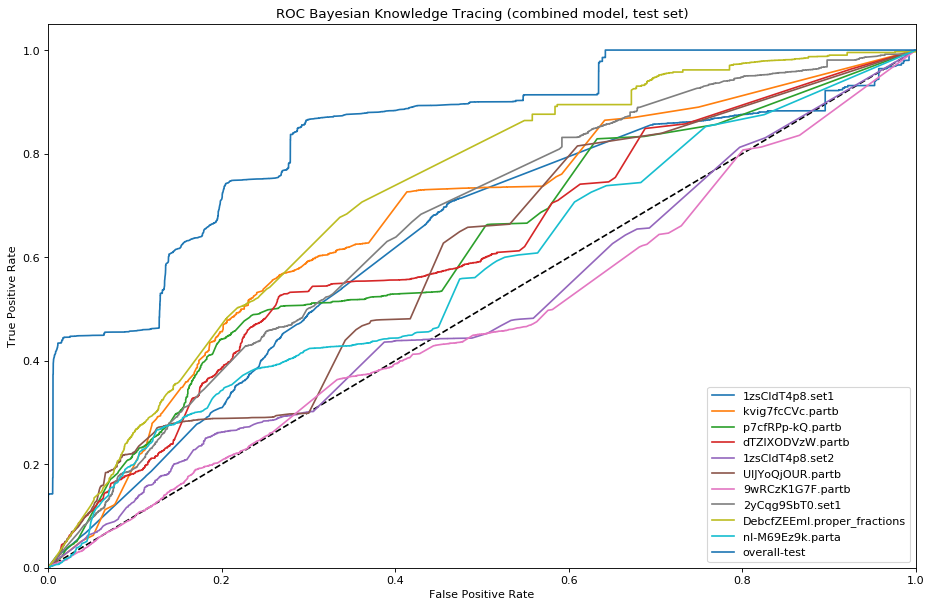

In [24]:
fig=plt.figure(figsize=(14, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Bayesian Knowledge Tracing (combined model, test set)')

for task_id in another_2:
    roc = calculate_auc(true_all_tasks['test'][task_id][-1] , predictions_all_tasks['test'][task_id][-1] , seqlen_all_tasks['test'][task_id][-1],plot=True)
    plt.plot(roc[1], roc[2], label=task_id)

roc = calculate_auc(true_all_tasks['test']['overall'][-1],predictions_all_tasks['test']['overall'][-1],c_seqlen['test']['overall'][-1],plot=True)
plt.plot(roc[1], roc[2], label='DKT (input combined)')

plt.legend(loc="lower right")

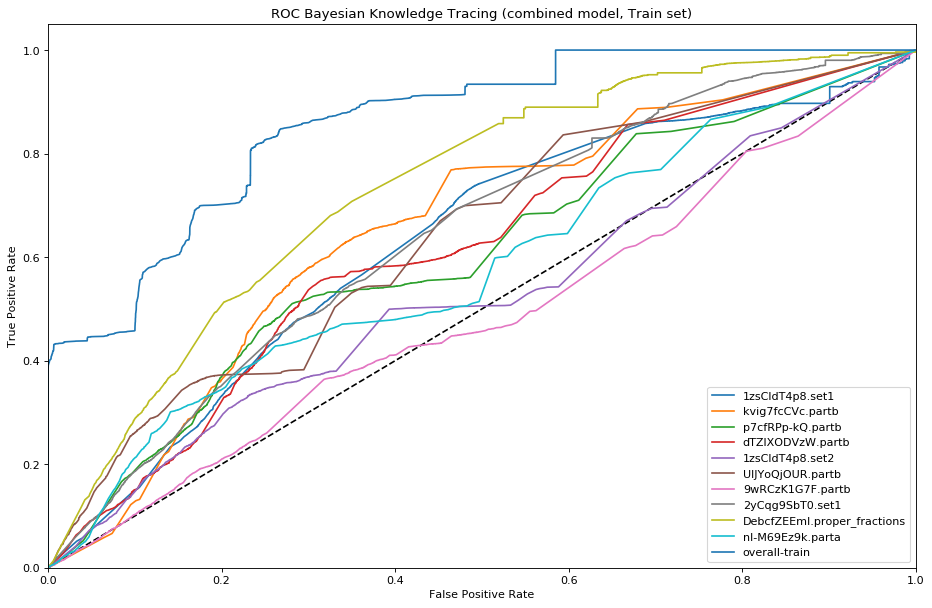

In [25]:
fig=plt.figure(figsize=(14, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Bayesian Knowledge Tracing (combined model, Train set)')

for task_id in another_2:
    roc = calculate_auc(true_all_tasks['train'][task_id][-1],predictions_all_tasks['train'][task_id][-1], seqlen_all_tasks['train'][task_id][-1], plot=True)
    plt.plot(roc[1], roc[2], label=task_id)

roc = calculate_auc(true_all_tasks['train']['overall'][-1],predictions_all_tasks['train']['overall'][-1],c_seqlen['train']['overall'][-1],plot=True)
plt.plot(roc[1], roc[2], label='overall-train')

plt.legend(loc="lower right")

test set roc plots


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


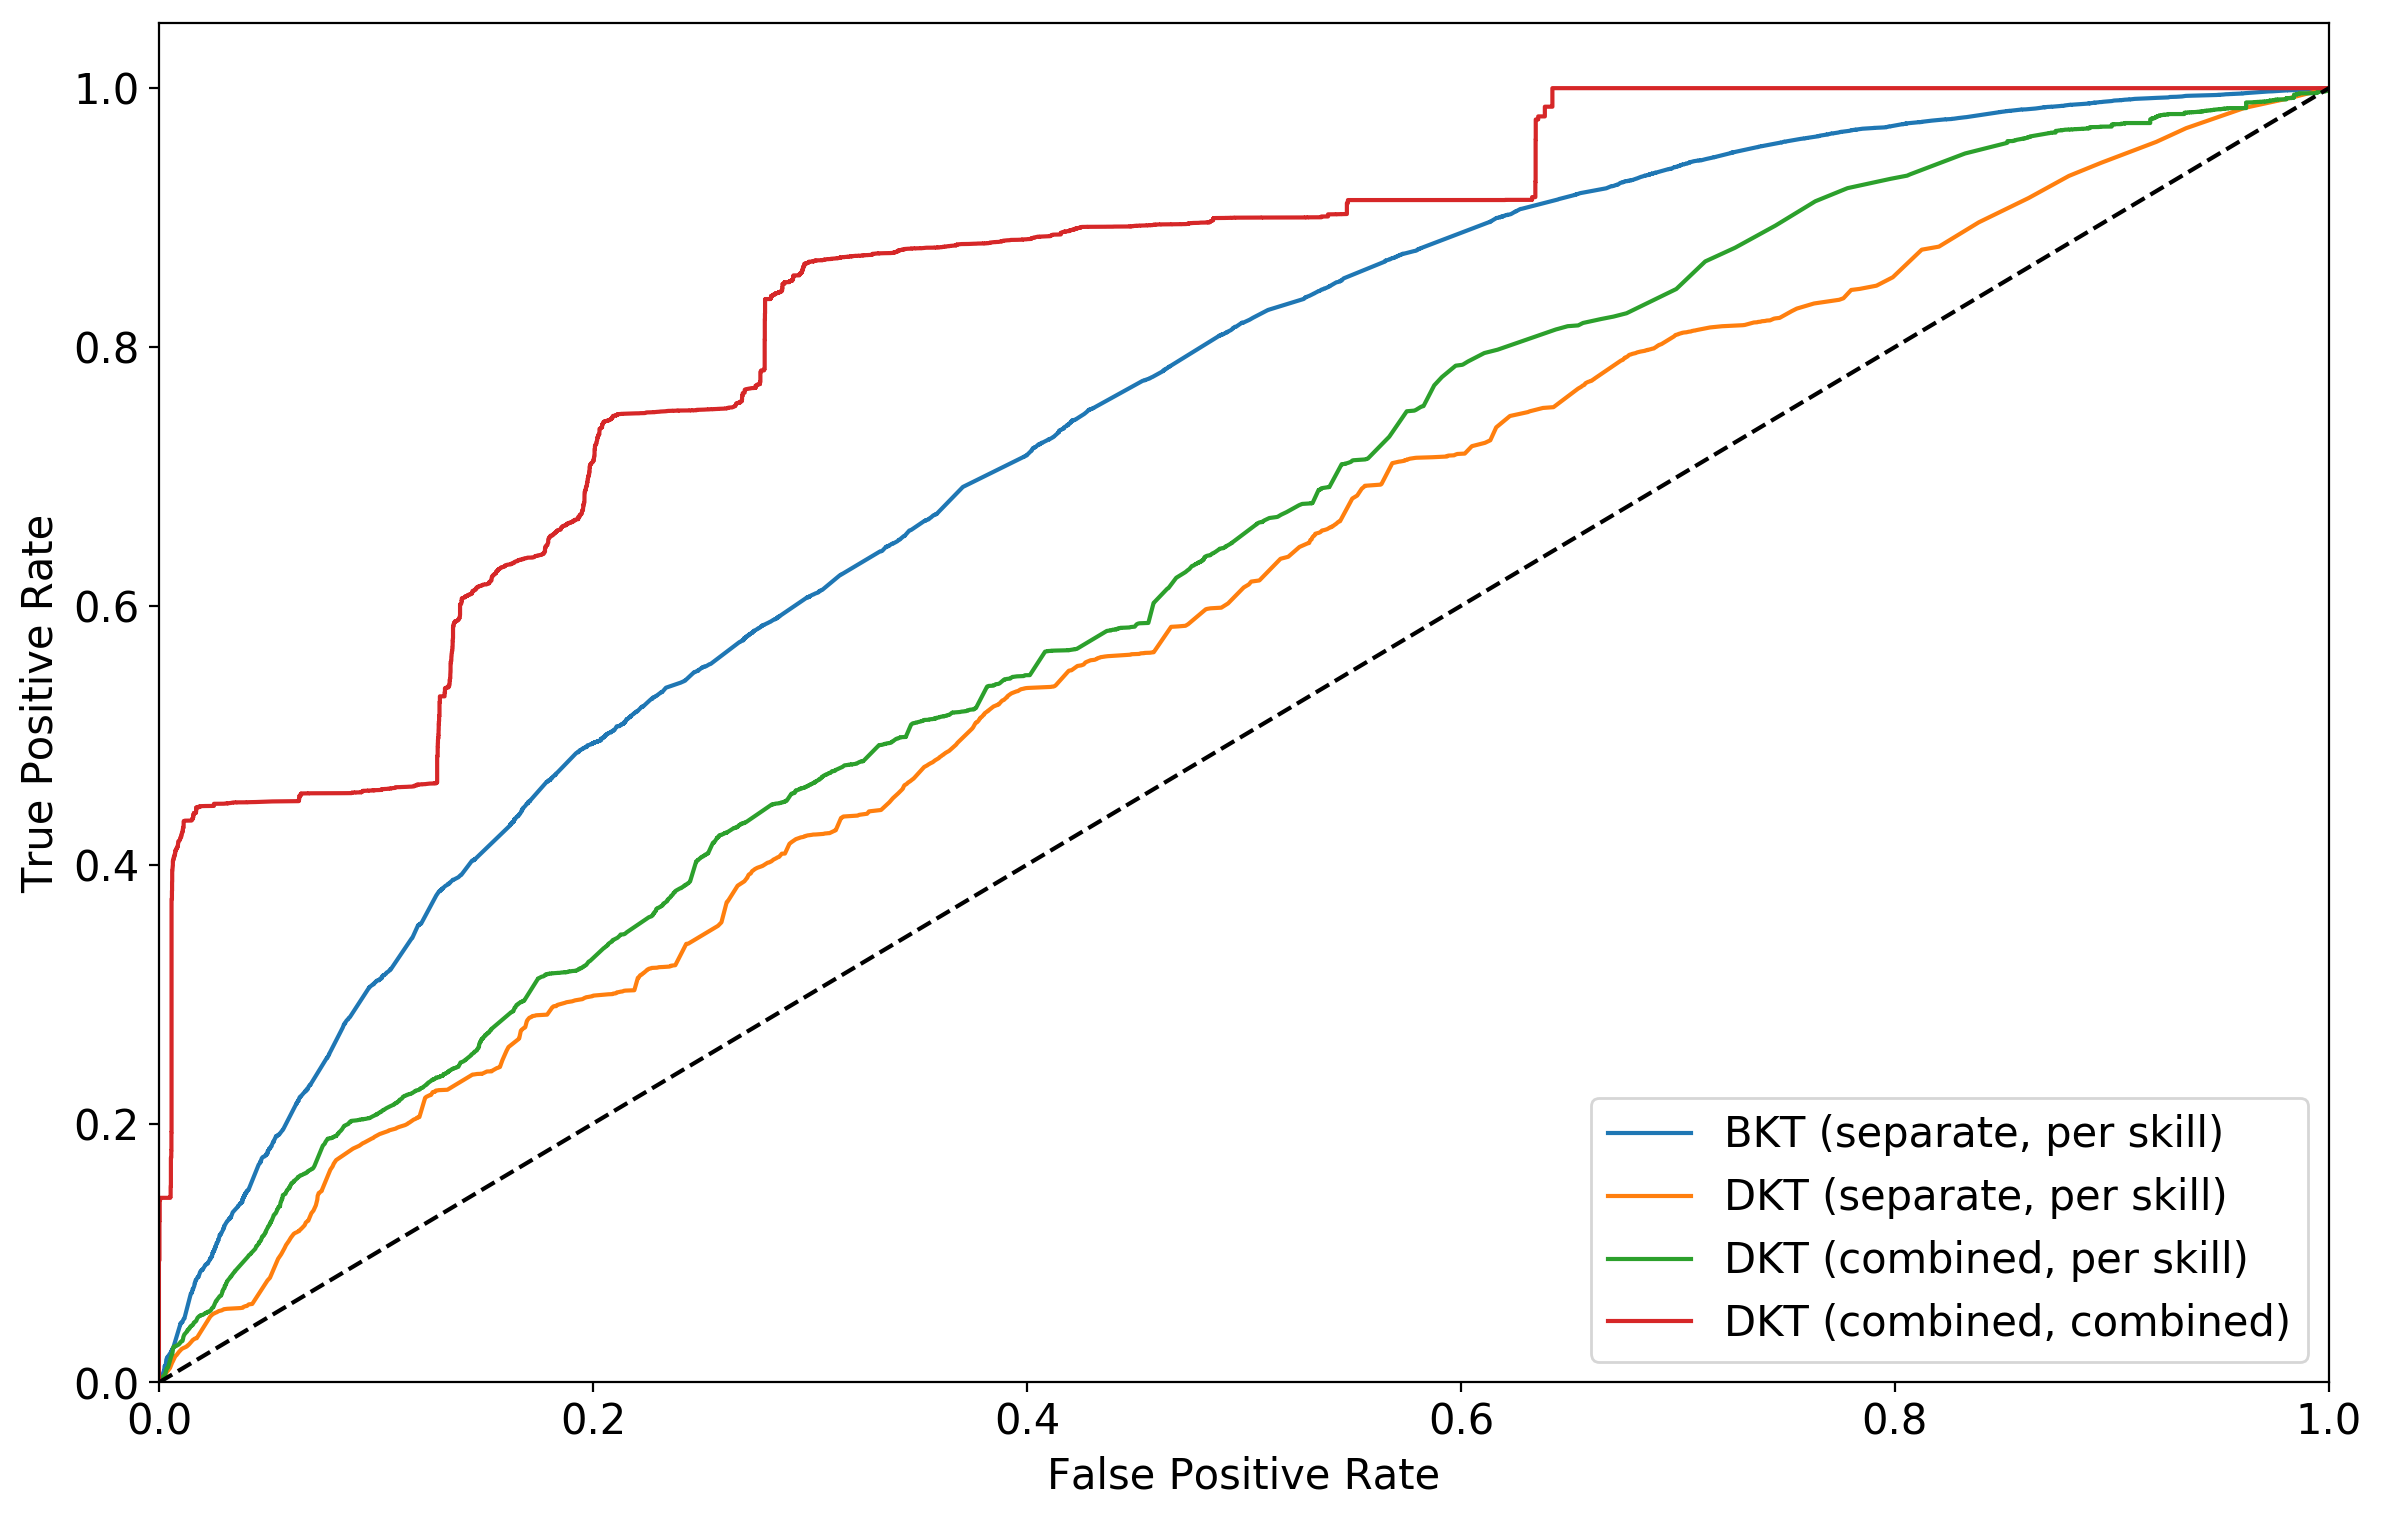

In [41]:
import matplotlib
print("test set roc plots")
fig=plt.figure(figsize=(14, 9), dpi= 200, facecolor='w', edgecolor='k')
matplotlib.rcParams.update({'font.size': 15})
#BKT (Separate, per skill)
filepath = "bkt_large_concat_roc.pickle"
roc_curves = pickle.load( open(filepath, "rb" ) )
for task_id, roc in roc_curves.items():
  plt.plot(roc[0], roc[1], label="BKT (separate, per skill)")

#DKT (Separate, per skill)
roc = load_obj('dkt_sep_roc_overall')
plt.plot(roc[1], roc[2], label='DKT (separate, per skill)')

#DKT (Combined, per skill)
roc = calculate_auc(tre,prd,sql,plot=True)
plt.plot(roc[1], roc[2], label='DKT (combined, per skill)')

#DKT (combined, combined)
roc = calculate_auc(true_all_tasks['test']['overall'][-1],predictions_all_tasks['test']['overall'][-1],c_seqlen['test']['overall'][-1],plot=True)
plt.plot(roc[1], roc[2], label='DKT (combined, combined)')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")
plt.savefig('final_roc_10x.png')

In [ ]:
fig, axs = plt.subplots(6,2, figsize=(20, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()

for i,value in enumerate(another_2):
    train_auc = seqlen_all_tasks['train'][value][:]
    test_auc = seqlen_all_tasks['test'][value][:]
    axs[i-1].plot(test_auc,label='test')
    axs[i-1].plot(train_auc,label='train')
    axs[i-1].set_ylim(0,1.1)
    axs[i-1].set_xlim(0,12)
    axs[i-1].set_xlabel("Epochs")
    axs[i-1].set_ylabel("AUC")
    axs[i-1].legend(loc="best")
    axs[i-1].set_title("Task ID = "+str(value))
    
train_auc = seqlen_all_tasks['train']['overall'][:]
test_auc = seqlen_all_tasks['test']['overall'][:]
axs[i].plot(test_auc,label='test')
axs[i].plot(train_auc,label='train')
axs[i].set_ylim(0,1.1)
axs[i].set_xlim(0,12)
axs[i].set_xlabel("Epochs")
axs[i].set_ylabel("AUC")
axs[i].legend(loc="best")
axs[i].set_title("Overall")

In [28]:
for i in another_2:
    print(i + " final train acc: " + str(calculate_auc(true_all_tasks['train'][i][-1],predictions_all_tasks['train'][i][-1], seqlen_all_tasks['train'][i][-1])) + "; final test acc: "+str(calculate_auc(true_all_tasks['test'][i][-1] , predictions_all_tasks['test'][i][-1] , seqlen_all_tasks['test'][i][-1])))

1zsCldT4p8.set1 final train acc: 0.6289166210723792; final test acc: 0.6245624035521604
kvig7fcCVc.partb final train acc: 0.6564077184051482; final test acc: 0.6704487911530165
p7cfRPp-kQ.partb final train acc: 0.6062274916439526; final test acc: 0.6216466179432918
dTZlXODVzW.partb final train acc: 0.6193964970353959; final test acc: 0.617139081151306
1zsCldT4p8.set2 final train acc: 0.5284124906897998; final test acc: 0.5015467069606274
UlJYoQjOUR.partb final train acc: 0.641236812070215; final test acc: 0.5981444656847307
9wRCzK1G7F.partb final train acc: 0.48541458131657245; final test acc: 0.47871445265697904
2yCqg9SbT0.set1 final train acc: 0.6438427312799883; final test acc: 0.6608558629403736
DebcfZEEmI.proper_fractions final train acc: 0.7341121571456878; final test acc: 0.7198420985764095
nl-M69Ez9k.parta final train acc: 0.5811787391612971; final test acc: 0.5723656704324992


**No longer maintained below this point.**<br>Training the model for hyperparameter (learning rate) tuning.

In [ ]:
# plot_lr = []
# plot_valid_auc_taskid = []
# plot_train_auc_taskid = []

# with tf.Session() as sess:
#     for l_r in learning_rate:
#         plot_lr.append(l_r)    
#         valid_taskid_list = []
#         for k_fold in range(1,maximum_position+1):
#             # Initialize the variables (i.e. assign their default value)
#             tf.reset_default_graph()
#             print(str(k_fold)+"-fold cross-validation")
#             sess.run(tf.global_variables_initializer())
#             sess.run(tf.local_variables_initializer())
#             assign_op = learning_tf_rate.assign(l_r)
#             sess.run(assign_op)
#             print("Current Learning Rate: "+str(learning_tf_rate.eval()))
#             train_set_seqlen, valid_set_seqlen, valid_set_x, valid_set_y, valid_set_y_taskid, train_set_x, train_set_y, train_set_y_taskid = get_next_train_valid_set(k_fold-1)
            
#             for step in range(1, training_steps+1):
#                 batch_x = train_set_x
#                 batch_y = train_set_y
#                 sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, y_taskid: train_set_y_taskid, seqlen_tf: train_set_seqlen})

#                 if step % display_step == 0 or step == 1:
#                     loss,trainAUC,trainOPTS = sess.run([cost, auc, opts], feed_dict={x: batch_x, y: batch_y, y_taskid: train_set_y_taskid, seqlen_tf: train_set_seqlen})
#                     #print status
#                     print("Step " + str(step) + ", Loss = " + str(loss) + ", Learning Rate = "+str(learning_tf_rate.eval()) + ", Train AUC:" + str(trainOPTS))
#             #calculate validation AUC
#             valid_auc_taskid, valid_opts_taskid = sess.run([auc, opts], feed_dict={x: valid_set_x, y: valid_set_y, y_taskid: valid_set_y_taskid, seqlen_tf: valid_set_seqlen})
#             print("Valid_auc_taskid: " + str(valid_opts_taskid) + " with k = "+str(k_fold))
#             valid_taskid_list.append(valid_opts_taskid)
#             print("Optimization Finished!")
    
#         #calculate training AUC (it should take both validation and training sets)
#         train_auc_taskid, train_opts_taskid = sess.run([auc, opts], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})

#         print("Train_auc_taskid: " + str(train_opts_taskid))
#         plot_train_auc_taskid.append(train_opts_taskid)
        
#         #take average of validation AUCs
#         valid_avg_taskid = np.mean(valid_taskid_list)
        
#         print("Average Valid_auc_taskid: " + str(valid_avg_taskid))
#         plot_valid_auc_taskid.append(valid_avg_taskid)

Plotting validation set ccssm auc across different learning rates.

In [ ]:
# plt.title("Training Set AUC")
# plt.xlabel("Learning Rate Index")
# plt.ylabel("AUC")
# plt.plot(plot_train_auc_taskid,'r--',label='train')
# plt.plot(plot_valid_auc_taskid,label='valid')
# plt.legend(loc='best', fancybox=True, framealpha=0.5)
# plt.show()
# print(learning_rate)

#http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/